# Logistic Regression AD Image Baseline

## Imports

In [1]:
import os
import pandas as pd

## Import data and create .csv

In [7]:
# Directory to MRI Images
base_dir = '/Users/benrandoing/Downloads/archive/GANAugmentedAD'
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

if not os.path.exists('datasetGAN.csv'):
    print("Processing Data")
    data = []

    for label, class_name in enumerate(classes):
        class_dir = os.path.join(base_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            data.append([image_path, label])

    df = pd.DataFrame(data, columns=['path', 'label'])
    df.to_csv('datasetGAN.csv', index=False)

Processing Data


## Data Loading and Pre-Processing

In [13]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)  # Shuffle the dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize image to 128x128
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

# Load the entire dataset
dataset = CustomDataset(csv_file='datasetGAN.csv', transform=transform)

# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [14]:
print(f'Training Samples: {len(train_dataset)}')
print(f'Validation Samples: {len(val_dataset)}')
print(f'Test Samples: {len(test_dataset)}')

Training Samples: 24012
Validation Samples: 5145
Test Samples: 5147


In [12]:
print(train_dataset)

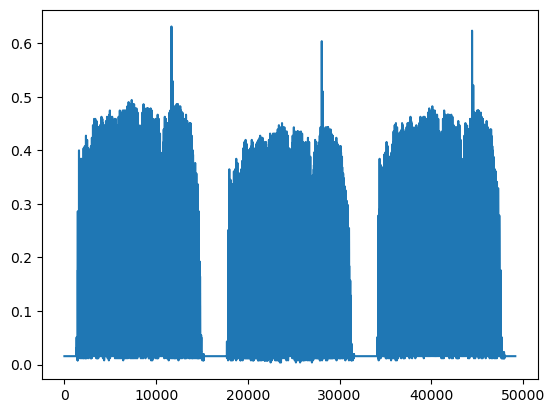

In [6]:
import matplotlib.pyplot as plt
plt.plot(train_dataset[0][0])
plt.show()

## Pytorch Logistic Regression Model

In [10]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

input_dim = 128*128*3  # Assuming the images are RGB
output_dim = 4  # Four classes

model = LogisticRegression(input_dim, output_dim)